In [1]:
#%pip install googlemaps

In [2]:
#%pip install geopy osmnx networkx scikit-learn

In [3]:
!python -m pip install --upgrade pip

In [4]:
%pip install --user python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [5]:
from dotenv import load_dotenv
import os

In [6]:
# Tu clave de API
# Cargar las variables de entorno desde el archivo .env
load_dotenv()

# Función para obtener una variable de entorno
def get_env_variable(var_name):
    value = os.getenv(var_name)
    if value is None:
        raise EnvironmentError(f"La variable de entorno {var_name} no está definida")
    return value

In [7]:
import googlemaps
from datetime import datetime


# Inicializa el cliente de Google Maps
gmaps = googlemaps.Client(key=get_env_variable('API_KEY'))

# Define los puntos de origen y destino
origen = 'Plaza Mayor, Lima, Peru'
destino = 'Aeropuerto Internacional Jorge Chávez, Lima, Peru'

# Obtén la ruta usando transporte público (buses, trenes, etc.)
now = datetime.now()
directions_result = gmaps.directions(origen,
                                    destino,
                                    mode="transit",
                                    departure_time=now)

# Imprimir la respuesta para ver los resultados
print(directions_result)


[{'bounds': {'northeast': {'lat': -12.0228882, 'lng': -77.02926479999999}, 'southwest': {'lat': -12.0451459, 'lng': -77.1076681}}, 'copyrights': 'Map data ©2024 Google', 'legs': [{'arrival_time': {'text': '6:00\u202fPM', 'time_zone': 'America/Lima', 'value': 1727046019}, 'departure_time': {'text': '5:04\u202fPM', 'time_zone': 'America/Lima', 'value': 1727042643}, 'distance': {'text': '10.9 km', 'value': 10890}, 'duration': {'text': '56 mins', 'value': 3376}, 'end_address': 'Jorge Chavez International Airport (LIM), Av. Elmer Faucett s/n, Callao 07031, Peru', 'end_location': {'lat': -12.0228882, 'lng': -77.1076681}, 'start_address': 'Lima Main Square, Jr. Junín cdra. 1, Lima 15001, Peru', 'start_location': {'lat': -12.0451459, 'lng': -77.02958740000001}, 'steps': [{'distance': {'text': '0.8 km', 'value': 830}, 'duration': {'text': '11 mins', 'value': 676}, 'end_location': {'lat': -12.0406097, 'lng': -77.0324694}, 'html_instructions': 'Walk to Puente Santa Rosa / Puente Trujillo', 'polyl

In [8]:
def filtrar_informacion(data):
    # Extraer detalles clave del trayecto
    distancia_total = data[0]['legs'][0]['distance']['text']
    duracion_total = data[0]['legs'][0]['duration']['text']
    hora_salida = data[0]['legs'][0]['departure_time']['text']
    hora_llegada = data[0]['legs'][0]['arrival_time']['text']
    punto_inicio = data[0]['legs'][0]['start_address']
    punto_llegada = data[0]['legs'][0]['end_address']
    
    # Información de transporte en bus
    bus_details = data[0]['legs'][0]['steps'][1]['transit_details']
    linea_bus = bus_details['line']['name']
    num_paradas = bus_details['num_stops']
    hora_salida_bus = bus_details['departure_time']['text']
    hora_llegada_bus = bus_details['arrival_time']['text']
    estacion_salida = bus_details['departure_stop']['name']
    estacion_llegada = bus_details['arrival_stop']['name']

    # Resumen de la información
    resumen = {
        "distancia_total": distancia_total ,
        "duracion_total": duracion_total,
        "hora_salida": hora_salida,
        "hora_llegada": hora_llegada,
        "punto_inicio": punto_inicio,
        "punto_llegada": punto_llegada,
        "transporte": {
            "linea_bus": linea_bus,
            "numero_paradas": num_paradas,
            "hora_salida_bus": hora_salida_bus,
            "hora_llegada_bus": hora_llegada_bus,
            "estacion_salida": estacion_salida,
            "estacion_llegada": estacion_llegada
        }
    }
    
    return resumen



In [9]:
resumen = filtrar_informacion(directions_result)

print(f"Distancia total: {resumen['distancia_total']}")
print(f"Duración total: {resumen['duracion_total']}")
print(f"Hora de salida: {resumen['hora_salida']}")
print(f"Hora de llegada: {resumen['hora_llegada']}")
print(f"Punto de inicio: {resumen['punto_inicio']}")
print(f"Punto de llegada: {resumen['punto_llegada']}")

print("\n--- Detalles del transporte en bus ---")
print(f"Línea de bus: {resumen['transporte']['linea_bus']}")
print(f"Número de paradas: {resumen['transporte']['numero_paradas']}")
print(f"Hora de salida del bus: {resumen['transporte']['hora_salida_bus']}")
print(f"Hora de llegada del bus: {resumen['transporte']['hora_llegada_bus']}")
print(f"Estación de salida: {resumen['transporte']['estacion_salida']}")
print(f"Estación de llegada: {resumen['transporte']['estacion_llegada']}")


Distancia total: 10.9 km
Duración total: 56 mins
Hora de salida: 5:04 PM
Hora de llegada: 6:00 PM
Punto de inicio: Lima Main Square, Jr. Junín cdra. 1, Lima 15001, Peru
Punto de llegada: Jorge Chavez International Airport (LIM), Av. Elmer Faucett s/n, Callao 07031, Peru

--- Detalles del transporte en bus ---
Línea de bus: jiron Puno, 469 - Puente Nuevo
Número de paradas: 27
Hora de salida del bus: 5:15 PM
Hora de llegada del bus: 5:53 PM
Estación de salida: Puente Santa Rosa / Puente Trujillo
Estación de llegada: Aeropuerto


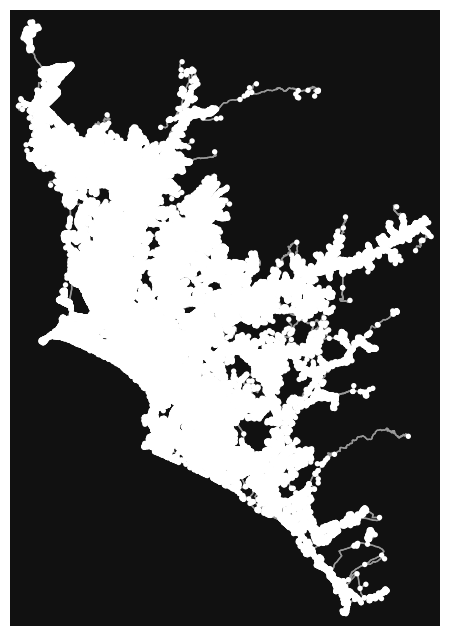

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [10]:
import osmnx as ox
import networkx as nx

# Descargar el grafo de la red vial de toda Lima
G = ox.graph_from_place('Lima, Peru', network_type='drive')

# Mostrar la red vial
ox.plot_graph(G)


Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.


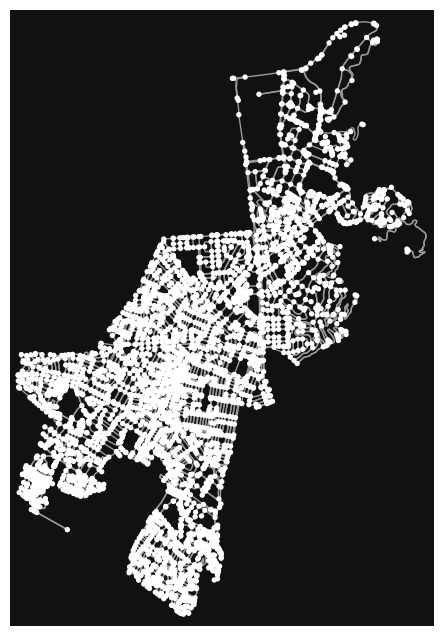

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [11]:
import googlemaps
import osmnx as ox
import networkx as nx
from datetime import datetime

# Get the real-time traffic data from Google Maps
def get_traffic_data(origin, destination):
    now = datetime.now()
    directions = gmaps.directions(
        origin, 
        destination, 
        mode="driving", 
        departure_time=now, 
        traffic_model="best_guess"  # You can change to 'pessimistic' or 'optimistic'
    )
    return directions

# Function to assign traffic times to graph edges
def add_traffic_to_graph(G, origin, destination):
    traffic_data = get_traffic_data(origin, destination)
    
    # Example: Extracting the first leg of the route and assigning to the graph
    for leg in traffic_data[0]['legs'][0]['steps']:
        start_lat = leg['start_location']['lat']
        start_lng = leg['start_location']['lng']
        end_lat = leg['end_location']['lat']
        end_lng = leg['end_location']['lng']
        
        # Find the closest graph nodes to these coordinates
        start_node = ox.distance.nearest_nodes(G, start_lng, start_lat)
        end_node = ox.distance.nearest_nodes(G, end_lng, end_lat)
        
        # Get the duration with traffic if available, otherwise use regular duration
        if 'duration_in_traffic' in leg:
            duration_with_traffic = leg['duration_in_traffic']['value']  # in seconds
        else:
            print("Traffic data not available for this segment, using regular duration.")
            duration_with_traffic = leg['duration']['value']  # fallback to normal duration
        
        # Add or update the edge with the new weight (time in seconds)
        if G.has_edge(start_node, end_node):
            G[start_node][end_node][0]['time'] = duration_with_traffic
        elif G.has_edge(end_node, start_node):
            G[end_node][start_node][0]['time'] = duration_with_traffic

    return G

# Example usage
G = ox.graph_from_place('Santiago de Surco, Lima, Peru', network_type='drive')
origin = "UPC Monterrico, Lima, Peru"
destination = "Jockey Plaza, Lima, Peru"

G_with_traffic = add_traffic_to_graph(G, origin, destination)

# Visualize the graph with traffic times as edge weights
ox.plot_graph(G_with_traffic)


In [12]:
# List of origins and destinations
locations = [
    ("Larcomar, Miraflores, Lima, Peru", "Parque Kennedy, Miraflores, Lima, Peru"),
    ("Plaza San Martín, Lima, Peru", "Parque de la Exposición, Lima, Peru"),
    ("Jirón de la Unión, Lima, Peru", "Circuito Mágico del Agua, Lima, Peru"),
    ("Universidad de Lima, Lima, Peru", "Jockey Plaza, Lima, Peru"),
    ("Museo Larco, Pueblo Libre, Lima, Peru", "Plaza Mayor, Lima, Peru"),
    ("Real Plaza Salaverry, Lima, Peru", "Universidad del Pacífico, Lima, Peru"),
    ("Estadio Nacional, Lima, Peru", "Gran Teatro Nacional, Lima, Peru"),
    ("Parque de las Leyendas, Lima, Peru", "Plaza Norte, Lima, Peru"),
    ("Parque El Olivar, San Isidro, Lima, Peru", "El Polo, Santiago de Surco, Lima, Peru"),
    ("Plaza Vea Chacarilla, Lima, Peru", "Open Plaza Angamos, Lima, Peru")
]

# Iterate over each origin-destination pair
for origin, destination in locations:
    try:
        print(f"Testing route from {origin} to {destination}")
        G_with_traffic = add_traffic_to_graph(G, origin, destination)
        print(f"Traffic data added for route from {origin} to {destination}")
    except Exception as e:
        print(f"Error for route from {origin} to {destination}: {e}")


Testing route from Larcomar, Miraflores, Lima, Peru to Parque Kennedy, Miraflores, Lima, Peru
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data added for route from Larcomar, Miraflores, Lima, Peru to Parque Kennedy, Miraflores, Lima, Peru
Testing route from Plaza San Martín, Lima, Peru to Parque de la Exposición, Lima, Peru
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data not available for this segment, using regular duration.
Traffic data added f

In [13]:
#%pip install mapbox

## USANDO MAPBOX

In [32]:
import osmnx as ox
import networkx as nx
from mapbox import Directions
from datetime import datetime

# Setup Mapbox API with your access token
mapbox_access_token = get_env_variable('API_KEY_MPBOX')
service = Directions(access_token=mapbox_access_token)

# Get traffic data from Mapbox
def get_traffic_data_mapbox(origin, destination):
    # Coordinates must be (longitude, latitude)
    origin_coords = (origin[1], origin[0])  # Convert to (lng, lat)
    destination_coords = (destination[1], destination[0])

    # Create features for the origin and destination
    features = [{
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': origin_coords
        }
    }, {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': destination_coords
        }
    }]

    # Make the request with the 'driving-traffic' profile
    response = service.directions(
        features=features,
        profile='mapbox/driving-traffic',
        overview='full',
        geometries='geojson',
    )
    
    # Parse the response
    if response.status_code == 200:
        data = response.json()
        return data['routes'][0]['legs'][0]['steps']
    else:
        raise Exception(f"Error fetching data from Mapbox: {response.status_code}")

# Function to assign traffic times to graph edges
def add_traffic_to_graph_mapbox(G, origin_coords, destination_coords):
    traffic_data = get_traffic_data_mapbox(origin_coords, destination_coords)
    
    # Extracting traffic data and assigning it to the graph edges
    for step in traffic_data:
        start_coords = step['geometry']['coordinates'][0]
        end_coords = step['geometry']['coordinates'][-1]

        # Find the closest graph nodes to these coordinates
        start_node = ox.distance.nearest_nodes(G, start_coords[0], start_coords[1])
        end_node = ox.distance.nearest_nodes(G, end_coords[0], end_coords[1])

        # Get the duration in seconds (traffic aware)
        duration_with_traffic = step['congestion']  # in seconds
        print(duration_with_traffic)
        # Add or update the edge with the new weight (time in seconds)
        if G.has_edge(start_node, end_node):
            G[start_node][end_node][0]['time'] = duration_with_traffic
        elif G.has_edge(end_node, start_node):
            G[end_node][start_node][0]['time'] = duration_with_traffic

    return G

# Example graph and test
G = ox.graph_from_place('Santiago de Surco, Lima, Peru', network_type='drive')

# Use latitude and longitude for origin and destination
origin_coords = (-12.107, -76.963)  # UPC Monterrico, Lima, Peru
destination_coords = (-12.089, -76.978)  # Jockey Plaza, Lima, Peru

G_with_traffic = add_traffic_to_graph_mapbox(G, origin_coords, destination_coords)



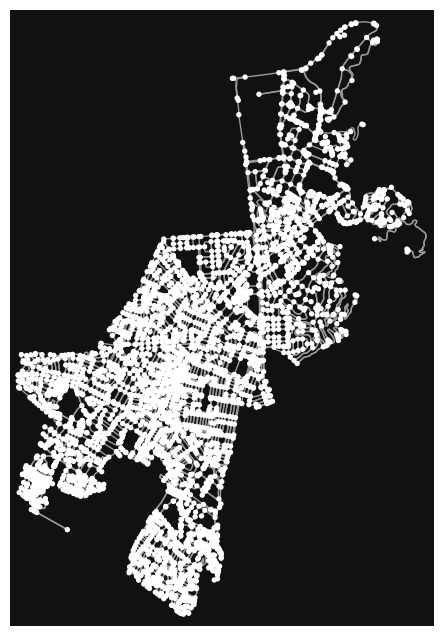

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [33]:
# Visualize the graph with traffic times as edge weights
ox.plot_graph(G_with_traffic)

In [25]:
import requests
import matplotlib.pyplot as plt

# Replace this with your own Mapbox access token
access_token = get_env_variable('API_KEY_MPBOX')

def get_coordinates_from_address(address):
    # Geocoding URL for Mapbox
    geocode_url = f"https://api.mapbox.com/geocoding/v5/mapbox.places/{address}.json"
    
    # Parameters for geocoding request
    geocode_params = {
        "access_token": access_token,
        "limit": 1  # Return only the best match
    }

    # Send the geocoding request
    response = requests.get(geocode_url, params=geocode_params)
    if response.status_code == 200:
        data = response.json()
        if data['features']:
            # Extract the coordinates
            coordinates = data['features'][0]['geometry']['coordinates']
            return coordinates  # [longitude, latitude]
        else:
            raise ValueError("No matching location found.")
    else:
        raise Exception(f"Geocoding API error: {response.status_code}")

def get_directions_from_addresses(address1, address2):
    # Get coordinates for the first address
    coords1 = get_coordinates_from_address(address1)
    
    # Get coordinates for the second address
    coords2 = get_coordinates_from_address(address2)
    
    # Prepare the coordinates string for the directions API
    coordinates = f"{coords1[0]},{coords1[1]};{coords2[0]},{coords2[1]}"  # "longitude,latitude;longitude,latitude"
    
    # Directions API URL
    directions_url = f"https://api.mapbox.com/directions/v5/mapbox/driving-traffic/{coordinates}"
    
    # Parameters for the directions request
    directions_params = {
        "access_token": access_token,
        "alternatives": "false",
        "steps": "true",
        "geometries": "geojson",
        "overview": "full",
        "annotations": "congestion"  # Updated to use supported annotations
    }

    # Send the directions request
    response = requests.get(directions_url, params=directions_params)
    if response.status_code == 200:
        directions = response.json()
        return directions
    else:
        raise Exception(f"Directions API error: {response.status_code}")

# Example Usage:
address1 = "UPC Monterrico, Lima, Peru"
address2 = "Jockey Plaza, Lima, Peru"

directions = get_directions_from_addresses(address1, address2)

# Print the directions result (as JSON or further processed)
print(directions)


{'routes': [{'weight_typical': 1387.233, 'duration_typical': 701.95, 'weight_name': 'auto', 'weight': 1415.702, 'duration': 725.584, 'distance': 4717.842, 'legs': [{'via_waypoints': [], 'admins': [{'iso_3166_1_alpha3': 'PER', 'iso_3166_1': 'PE'}], 'annotation': {'congestion': ['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'low', 'low', 'low', 'unknown', 'unknown', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', '

In [18]:
def handle_unknown_congestion(congestion_data):
    # Reemplazar 'unknown' con un valor predeterminado, como 'low'
    return ['low' if level == 'unknown' else level for level in congestion_data]

# En el lugar donde procesas la respuesta:
if 'congestion' in directions['routes'][0]['legs'][0]['annotation']:
    congestion_levels = directions['routes'][0]['legs'][0]['annotation']['congestion']
    congestion_levels = handle_unknown_congestion(congestion_levels)


In [24]:
# Extract route coordinates
if 'routes' in directions and directions['routes']:
    route = directions['routes'][0]  # Assuming the first route
    geometry = route['geometry']
    if 'coordinates' in geometry:
        route_coordinates = geometry['coordinates']
        print("Route Coordinates:")
        for coord in route_coordinates:
            print(f"  - {coord[0]}, {coord[1]} (longitude, latitude)")  # Access longitude and latitude
    else:
        print("No route coordinates found in the response.")
else:
    print("Error: No routes found in the directions response.")

Route Coordinates:
  - -76.962965, -12.103788 (longitude, latitude)
  - -76.962481, -12.103428 (longitude, latitude)
  - -76.962459, -12.103417 (longitude, latitude)
  - -76.962443, -12.103418 (longitude, latitude)
  - -76.962433, -12.103428 (longitude, latitude)
  - -76.962424, -12.103445 (longitude, latitude)
  - -76.962374, -12.103578 (longitude, latitude)
  - -76.962354, -12.103601 (longitude, latitude)
  - -76.962302, -12.103627 (longitude, latitude)
  - -76.962317, -12.103581 (longitude, latitude)
  - -76.962361, -12.103473 (longitude, latitude)
  - -76.962479, -12.10322 (longitude, latitude)
  - -76.96249, -12.103197 (longitude, latitude)
  - -76.962529, -12.103117 (longitude, latitude)
  - -76.962581, -12.103043 (longitude, latitude)
  - -76.962634, -12.102967 (longitude, latitude)
  - -76.96274, -12.102836 (longitude, latitude)
  - -76.962829, -12.102746 (longitude, latitude)
  - -76.962882, -12.102693 (longitude, latitude)
  - -76.962911, -12.102672 (longitude, latitude)
  - 